## Семинар 3 "Определение ключевых точек лица"

# Подготовительная задача 1

Сделать из линейной регрессии nn.sequental двухслойную сеть

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from torchvision import transforms, utils
from torch import nn
from torch import optim
from torch.autograd import Variable
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [3]:
in_1 = 784
out_1 = 100
in_2 = 100
out_2 = 10

model = torch.nn.Sequential(torch.nn.Linear(in_1, out_1), torch.nn.ReLU (), torch.nn.Linear(in_2, out_2))

# Подготовительная задача 2

Используя структуру сети Sequental в pytorch реализовать и обучить классификатор цифр из MNIST
(повторить первый и второй пункты из прошлого задания )

epoch 9, loss:0.04959493130451

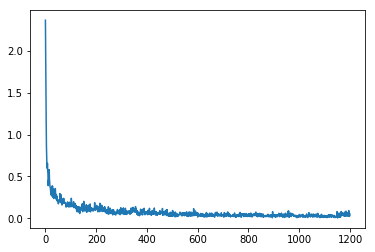

In [4]:
model = torch.nn.Sequential(torch.nn.Linear(784, 100), torch.nn.ELU (),
                            torch.nn.Linear(100, 100), torch.nn.ELU (),
                            torch.nn.Linear(100, 10))

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.CrossEntropyLoss()
error = []
for epoch in range (10):
    for batch_idx, (x, target) in enumerate(train_loader):
        x = Variable (x.view(x.size(0), -1), requires_grad=True)
        target = Variable (target, requires_grad=False)
        optimizer.zero_grad ()
        y_pred = model(x)
        loss = loss_fn(y_pred, target)
        loss.backward()
        optimizer.step()
        error.append (loss.data.numpy ().mean ())
        sys.stdout.write ("\repoch {}, loss:{}".format (epoch, loss.data.numpy ().mean ()))
    
plt.plot (error)

test error mean:  0.10478


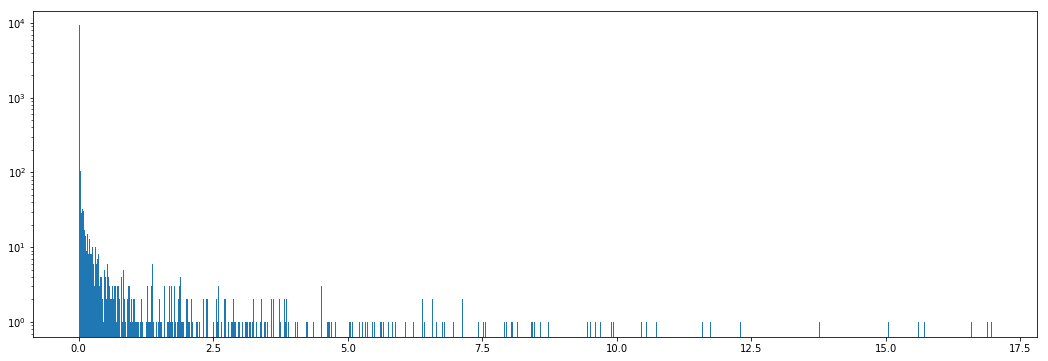

In [5]:
error = []
for batch_idx, (x, target) in enumerate(test_loader):
    x = Variable (x.view(x.size(0), -1), requires_grad=True)
    target = Variable (target, requires_grad=False)
    y_pred = model(x)
    loss = loss_fn(y_pred, target)
    error.append (loss.data.numpy ().mean ())

print ("test error mean: ", np.array (error).mean ())
plt.figure (figsize=(18,6))
plt.hist (error, bins=1000, log=True)
plt.show ()

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[  7.  41.]
 [  8.  51.]
 [ 10.  60.]
 [ 13.  70.]]


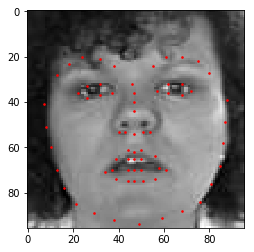

In [6]:
landmarks_frame = pd.read_csv('../../dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('../../dataset/train/', img_name)),
               landmarks)
plt.show()

In [7]:


class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.ix[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.ix[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
 
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

transformed_dataset_train = FaceLandmarksDataset(csv_file='../../dataset/train/face_landmarks.csv',
                                           root_dir='../../dataset/train/',
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]))

dataloader = DataLoader(transformed_dataset_train, batch_size=500,
                        shuffle=True, )


transformed_dataset_test = FaceLandmarksDataset(csv_file='../../dataset/test/face_landmarks.csv',
                                           root_dir='../../dataset/test/',
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]))

dataloader_test = DataLoader(transformed_dataset_test, batch_size=1,
                        shuffle=True, )

In [8]:
def fully_connected (arc, last_nonlin=False, nonlin='sigmoid'):
        layers = []
        for i in xrange (len(arc) - 1):
            layers.append (nn.Linear(arc[i], arc[i+1]))
            if i != len (arc) - 2 or last_nonlin:
                if nonlin == 'sigmoid':
                    layers.append (nn.Sigmoid ())
                if nonlin == 'relu':
                    layers.append (nn.ReLU ())
                if nonlin == 'elu':
                    layers.append (nn.ELU ())

        return nn.Sequential (*layers)

In [9]:
class AE (nn.Module):
    def __init__ (self, arc, nonlin):
        super (AE, self).__init__()
        # create encoder :
        self.model = fully_connected (arc, nonlin=nonlin)
        
    def forward (self, X):
        return self.model (X)

In [10]:
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

In [31]:
model = AE([96 ** 2, 439, 200,136], 'sigmoid')
loss = nn.MSELoss ()
optimizer = optim.Adam (model.parameters (), lr=0.1)

 9 17.5185375214

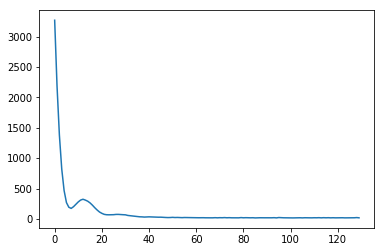

error mean:  18.5446819686


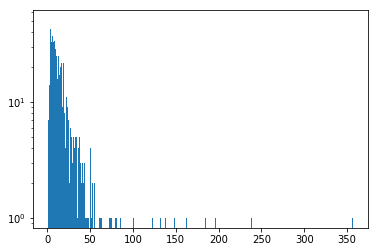

In [32]:
error = []
for epoch in xrange (10):
    losses = []
    for batch_idx, sample in enumerate(dataloader):
        model.zero_grad ()
        
        x = sample['image'].type (torch.FloatTensor)
        target = sample['landmarks']
        x_batch = Variable (x.view(x.size(0), -1))
        target = Variable (target.view (target.size (0), -1), requires_grad=False)
        y_batch = target.type (torch.FloatTensor)
        result = model (x_batch)
        loss_batch = loss (result, y_batch)
        loss_batch.backward ()
        optimizer.step ()
        losses.append (loss_batch.data[0])
        sys.stdout.write ('\r {} {}'.format (epoch, np.mean (losses)))
    error.extend (losses)

plt.plot (error)
plt.show ()
test_error = []
for batch_idx, sample in enumerate(dataloader_test):
    model.zero_grad ()

    x = sample['image'].type (torch.FloatTensor)
    target = sample['landmarks']
    x_batch = Variable (x.view(x.size(0), -1))
    target = Variable (target.view (target.size (0), -1), requires_grad=False)
    y_batch = target.type (torch.FloatTensor)
    result = model (x_batch)
    loss_batch = loss (result, y_batch)
    test_error.append (loss_batch.data.mean ())

print ('error mean: ', np.mean (test_error))
plt.hist (test_error, log=True, bins=1000)
plt.show ()

In [33]:
def show_landmarks(img, marks):
    im_size = img.size(1)
    grid = utils.make_grid(img)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.scatter(marks[ :, 0].numpy(),
                    marks[:, 1].numpy(),
                    s=10, marker='.', c='r')

def draw_one ():
    for batch_idx, sample in enumerate(dataloader):
        x = sample['image'].type (torch.FloatTensor)
        x = Variable (x.view(x.size(0), -1))
        y_pred = model(x)
        y_pred = y_pred.view (sample['landmarks'].size ())
        show_landmarks (sample['image'][0], y_pred.data[0])
        break

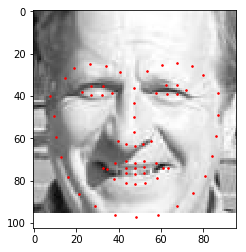

In [37]:
draw_one ()

 9 147.207875178

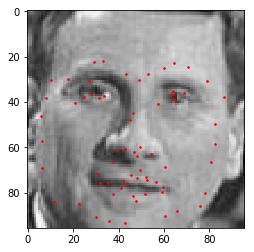

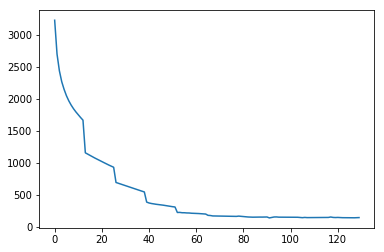

error mean:  151.48353541


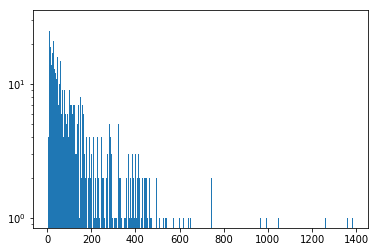

In [62]:
model = AE([96 ** 2, 1000, 200,136], 'relu')
loss = nn.MSELoss ()
optimizer = optim.Adam (model.parameters (), lr=0.00007)

error = []
for epoch in xrange (10):
    losses = []
    for batch_idx, sample in enumerate(dataloader):
        model.zero_grad ()
        
        x = sample['image'].type (torch.FloatTensor)
        target = sample['landmarks']
        x_batch = Variable (x.view(x.size(0), -1))
        target = Variable (target.view (target.size (0), -1), requires_grad=False)
        y_batch = target.type (torch.FloatTensor)
        result = model (x_batch)
        loss_batch = loss (result, y_batch)
        loss_batch.backward ()
        optimizer.step ()
        losses.append (loss_batch.data[0])
        sys.stdout.write ('\r {} {}'.format (epoch, loss_batch.data.mean ()))
        error.append (np.mean (losses))
    sys.stdout.write ('\r {} {}'.format (epoch, np.mean (losses)))
    
draw_one ()
plt.show ()
plt.plot (error)
plt.show ()

test_error = []
for batch_idx, sample in enumerate(dataloader_test):
    model.zero_grad ()

    x = sample['image'].type (torch.FloatTensor)
    target = sample['landmarks']
    x_batch = Variable (x.view(x.size(0), -1))
    target = Variable (target.view (target.size (0), -1), requires_grad=False)
    y_batch = target.type (torch.FloatTensor)
    result = model (x_batch)
    loss_batch = loss (result, y_batch)
    test_error.append (loss_batch.data.mean ())

print ('error mean: ', np.mean (test_error))
plt.hist (test_error, log=True, bins=1000)
plt.show ()

 9 147.737902715

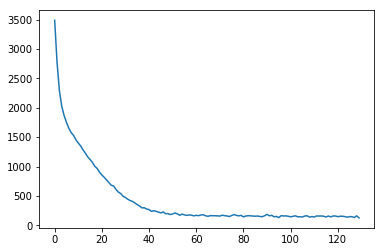

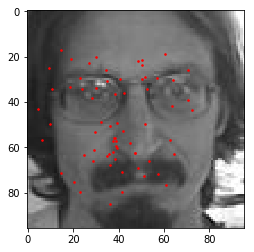

error mean:  154.62269781


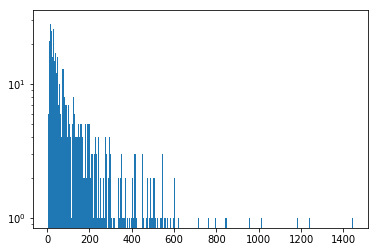

In [66]:
model = AE([96 ** 2, 500, 200,136], 'elu')
loss = nn.MSELoss ()
optimizer = optim.Adam (model.parameters (), lr=0.0001)

error = []
for epoch in xrange (10):
    losses = []
    for batch_idx, sample in enumerate(dataloader):
        model.zero_grad ()
        
        x = sample['image'].type (torch.FloatTensor)
        target = sample['landmarks']
        x_batch = Variable (x.view(x.size(0), -1))
        target = Variable (target.view (target.size (0), -1), requires_grad=False)
        y_batch = target.type (torch.FloatTensor)
        result = model (x_batch)
        loss_batch = loss (result, y_batch)
        loss_batch.backward ()
        optimizer.step ()
        losses.append (loss_batch.data[0])
        sys.stdout.write ('\r {} {}'.format (epoch, np.mean (losses)))
    error.extend (losses)

    
plt.plot (error)
plt.show ()
    
draw_one ()
plt.show ()

test_error = []
for batch_idx, sample in enumerate(dataloader_test):
    model.zero_grad ()

    x = sample['image'].type (torch.FloatTensor)
    target = sample['landmarks']
    x_batch = Variable (x.view(x.size(0), -1))
    target = Variable (target.view (target.size (0), -1), requires_grad=False)
    y_batch = target.type (torch.FloatTensor)
    result = model (x_batch)
    loss_batch = loss (result, y_batch)
    test_error.append (loss_batch.data.mean ())

print ('error mean: ', np.mean (test_error))
plt.hist (test_error, log=True, bins=1000)
plt.show ()

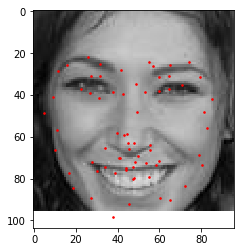

In [108]:
draw_one ()